# Benchmark: `sample_batched` vs For-Loop Sampling

This notebook compares the performance of the new `sample_batched` method against
the traditional approach of calling `sample` in a for-loop for multiple observations.

We verify:
1. **Timing**: How much faster is batched sampling?
2. **Distribution**: Do both methods produce samples from the same posterior?

In [1]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from npe_pfn.npe_pfn import NPE_PFN_Core

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## Setup: Simple Linear Gaussian Model

We use a simple model where the ground truth posterior is analytically tractable:
- Prior: $\theta \sim \mathcal{N}(0, I)$
- Likelihood: $x | \theta \sim \mathcal{N}(A\theta + b, \sigma^2 I)$

In [13]:
# Model dimensions
theta_dim = 3
obs_dim = 10
noise_std = 0.1

# Create linear model: y = A @ theta + b + noise
torch.manual_seed(42)
A = torch.randn(obs_dim, theta_dim)
b = torch.randn(obs_dim)

def simulator(theta):
    """Linear Gaussian simulator"""
    return theta @ A.T + b + noise_std * torch.randn(theta.shape[0], obs_dim)

# Prior
prior = torch.distributions.MultivariateNormal(
    loc=torch.zeros(theta_dim),
    covariance_matrix=torch.eye(theta_dim)
)

print(f"Model: theta_dim={theta_dim}, obs_dim={obs_dim}")
print(f"Linear transform A:\n{A}")
print(f"Bias b: {b}")

Model: theta_dim=3, obs_dim=10
Linear transform A:
tensor([[ 1.9269,  1.4873,  0.9007],
        [-2.1055,  0.6784, -1.2345],
        [-0.0431, -1.6047, -0.7521],
        [ 1.6487, -0.3925, -1.4036],
        [-0.7279, -0.5594, -2.3169],
        [-0.2168, -1.3847, -0.8712],
        [-0.2234,  1.7174,  0.3189],
        [-0.4245, -0.8286,  0.3309],
        [-1.5576,  0.9956, -0.8798],
        [-0.6011, -1.2742,  2.1228]])
Bias b: tensor([-0.0915,  0.2352,  2.2440,  0.5817,  0.4528,  0.6410,  0.5200,  0.5567,
         0.0744,  0.7113])


In [14]:
# Generate training data
n_train = 1000
theta_train = prior.sample((n_train,))
x_train = simulator(theta_train)

print(f"Training data: theta {theta_train.shape}, x {x_train.shape}")

# Initialize model (using NPE_PFN_Core for true batched sampling without filtering)
model = NPE_PFN_Core(prior=prior)
model.append_simulations(theta_train, x_train)
print("Model initialized and data appended.")

Training data: theta torch.Size([1000, 3]), x torch.Size([1000, 10])
Model initialized and data appended.


## Benchmark: Timing Comparison

Compare sampling time for multiple observations:
1. **For-loop**: Call `sample()` once per observation
2. **Batched**: Call `sample_batched()` once for all observations

In [15]:
def sample_with_loop(model, x_obs, n_samples):
    """Sample using a for-loop over observations."""
    samples_list = []
    for i in range(x_obs.shape[0]):
        samples = model.sample(
            sample_shape=torch.Size([n_samples]),
            x=x_obs[i:i+1]
        )
        samples_list.append(samples)
    return torch.stack(samples_list)  # [n_obs, n_samples, theta_dim]


def sample_batched_method(model, x_obs, n_samples):
    """Sample using the batched method."""
    return model.sample_batched(
        x=x_obs,
        sample_shape=torch.Size([n_samples])
    )  # [n_obs, n_samples, theta_dim]

In [16]:
# Warm-up runs
print("Warming up...")
x_warmup = torch.randn(2, obs_dim)
_ = sample_with_loop(model, x_warmup, 10)
_ = sample_batched_method(model, x_warmup, 10)
print("Warm-up complete.")

Warming up...
Warm-up complete.


In [17]:
# Benchmark parameters
n_obs_values = [5, 10, 20, 50]
n_samples_per_obs = 100

results = []

print("Running benchmark...")
print(f"{'n_obs':>6} | {'Loop (s)':>10} | {'Batched (s)':>12} | {'Speedup':>8}")
print("-" * 50)

for n_obs in n_obs_values:
    # Generate test observations
    theta_test = prior.sample((n_obs,))
    x_test = simulator(theta_test)
    
    # Time for-loop method
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    start = time.perf_counter()
    samples_loop = sample_with_loop(model, x_test, n_samples_per_obs)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    time_loop = time.perf_counter() - start
    
    # Time batched method
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    start = time.perf_counter()
    samples_batched = sample_batched_method(model, x_test, n_samples_per_obs)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    time_batched = time.perf_counter() - start
    
    speedup = time_loop / time_batched if time_batched > 0 else float('inf')
    
    results.append({
        'n_obs': n_obs,
        'time_loop': time_loop,
        'time_batched': time_batched,
        'speedup': speedup,
        'samples_loop': samples_loop,
        'samples_batched': samples_batched,
        'x_test': x_test,
        'theta_test': theta_test
    })
    
    print(f"{n_obs:>6} | {time_loop:>10.4f} | {time_batched:>12.4f} | {speedup:>7.2f}x")

Running benchmark...
 n_obs |   Loop (s) |  Batched (s) |  Speedup
--------------------------------------------------
     5 |     8.2832 |       2.6127 |    3.17x
    10 |    16.2372 |       3.5990 |    4.51x
    20 |    33.8342 |       6.3405 |    5.34x
    50 |    87.1265 |      12.3774 |    7.04x


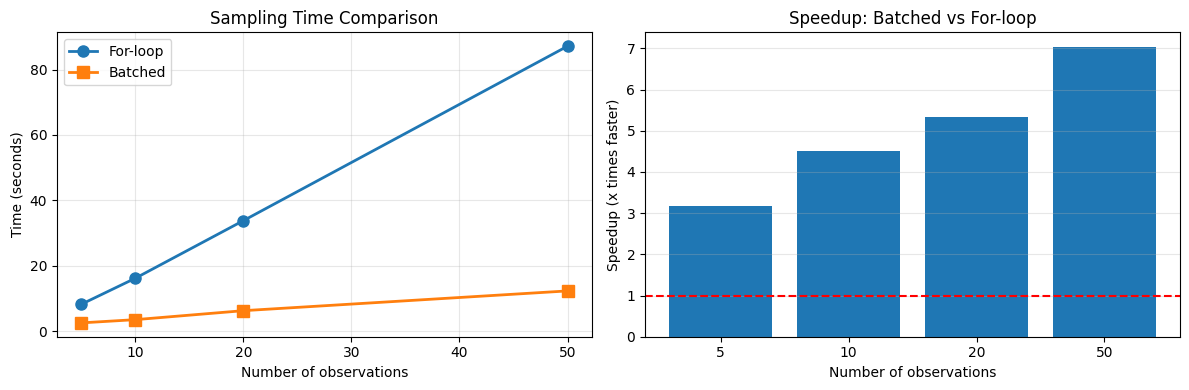

In [18]:
# Plot timing results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

n_obs_arr = [r['n_obs'] for r in results]
time_loop_arr = [r['time_loop'] for r in results]
time_batched_arr = [r['time_batched'] for r in results]
speedup_arr = [r['speedup'] for r in results]

# Timing comparison
ax1 = axes[0]
ax1.plot(n_obs_arr, time_loop_arr, 'o-', label='For-loop', linewidth=2, markersize=8)
ax1.plot(n_obs_arr, time_batched_arr, 's-', label='Batched', linewidth=2, markersize=8)
ax1.set_xlabel('Number of observations')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Sampling Time Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Speedup
ax2 = axes[1]
ax2.bar(range(len(n_obs_arr)), speedup_arr, tick_label=[str(n) for n in n_obs_arr])
ax2.axhline(y=1, color='r', linestyle='--', label='No speedup')
ax2.set_xlabel('Number of observations')
ax2.set_ylabel('Speedup (x times faster)')
ax2.set_title('Speedup: Batched vs For-loop')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Distribution Comparison

Verify that both sampling methods produce samples from the same distribution.
We use:
1. Visual comparison (histograms)
2. Statistical test (2-sample Kolmogorov-Smirnov test)

In [19]:
# Use the results from n_obs=20 for detailed comparison
result_idx = 2  # n_obs=20
r = results[result_idx]

samples_loop = r['samples_loop']  # [n_obs, n_samples, theta_dim]
samples_batched = r['samples_batched']

print(f"Comparing distributions for n_obs={r['n_obs']}")
print(f"Samples shape - Loop: {samples_loop.shape}, Batched: {samples_batched.shape}")

Comparing distributions for n_obs=20
Samples shape - Loop: torch.Size([20, 100, 3]), Batched: torch.Size([20, 100, 3])


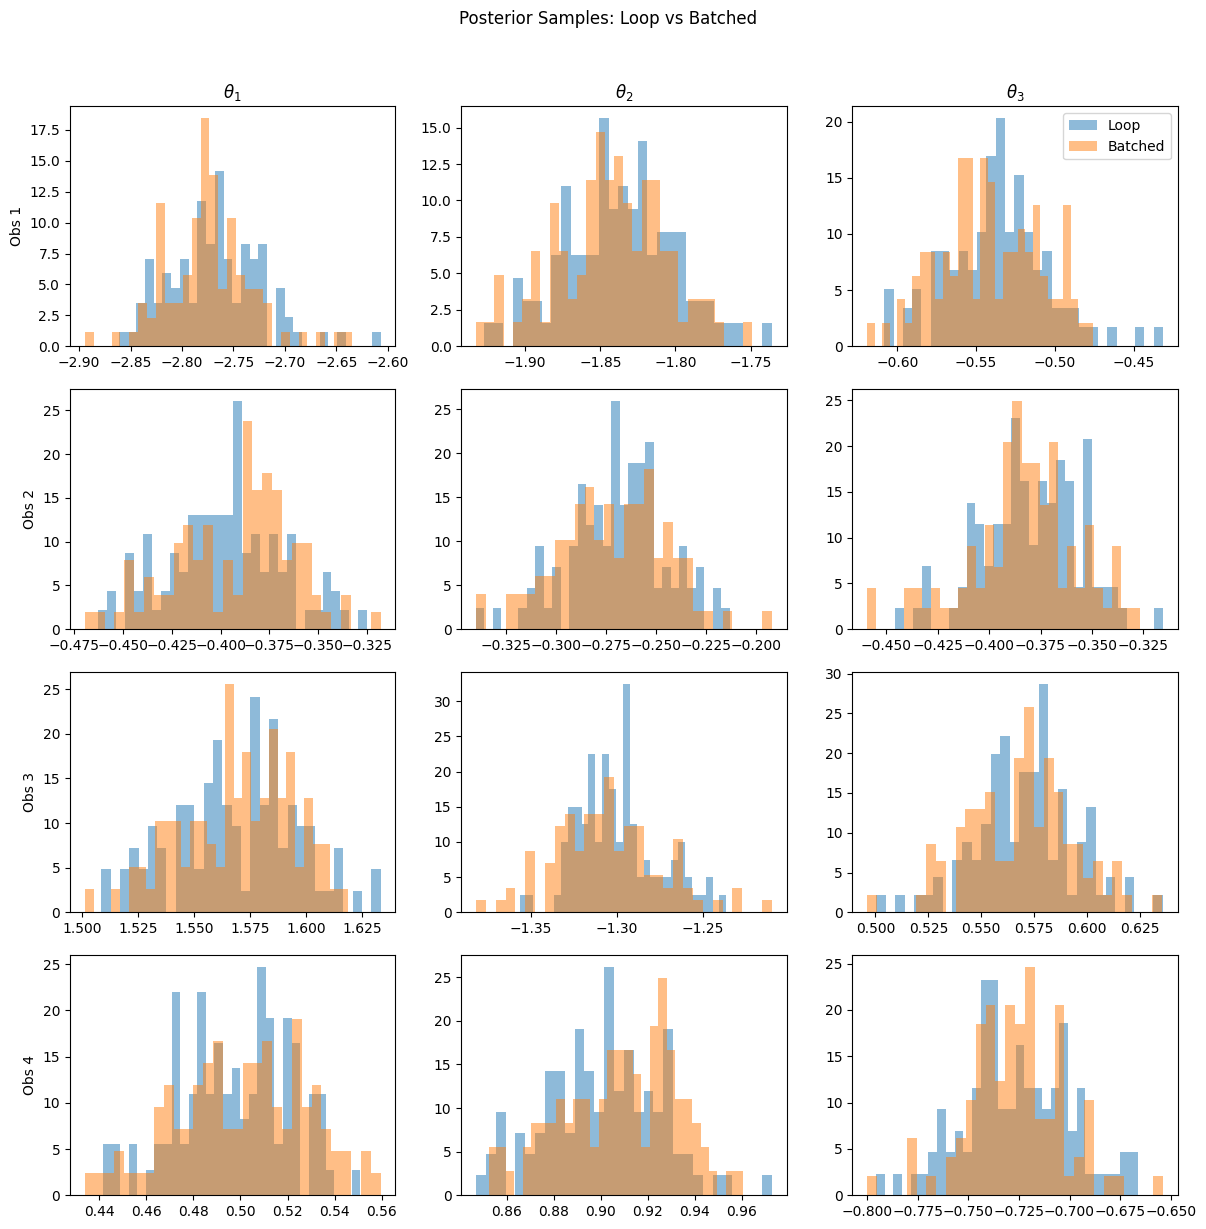

In [20]:
# Visual comparison: histograms for first few observations
n_show = min(4, r['n_obs'])
fig, axes = plt.subplots(n_show, theta_dim, figsize=(4*theta_dim, 3*n_show))

if n_show == 1:
    axes = axes.reshape(1, -1)

for obs_idx in range(n_show):
    for dim_idx in range(theta_dim):
        ax = axes[obs_idx, dim_idx]
        
        loop_samples = samples_loop[obs_idx, :, dim_idx].numpy()
        batched_samples = samples_batched[obs_idx, :, dim_idx].numpy()
        
        ax.hist(loop_samples, bins=30, alpha=0.5, label='Loop', density=True)
        ax.hist(batched_samples, bins=30, alpha=0.5, label='Batched', density=True)
        
        if obs_idx == 0:
            ax.set_title(f'$\\theta_{dim_idx+1}$')
        if dim_idx == 0:
            ax.set_ylabel(f'Obs {obs_idx+1}')
        if obs_idx == 0 and dim_idx == theta_dim - 1:
            ax.legend()

plt.suptitle('Posterior Samples: Loop vs Batched', y=1.02)
plt.tight_layout()
plt.show()

In [21]:
# Statistical test: 2-sample KS test for each observation and dimension
print("Kolmogorov-Smirnov Test Results")
print("(p-value > 0.05 suggests samples come from the same distribution)")
print()
print(f"{'Obs':>4} | {'Dim':>4} | {'KS Stat':>10} | {'p-value':>10} | {'Same Dist?':>12}")
print("-" * 55)

all_pvalues = []
for obs_idx in range(min(10, r['n_obs'])):  # Test first 10 observations
    for dim_idx in range(theta_dim):
        loop_samples = samples_loop[obs_idx, :, dim_idx].numpy()
        batched_samples = samples_batched[obs_idx, :, dim_idx].numpy()
        
        ks_stat, p_value = stats.ks_2samp(loop_samples, batched_samples)
        all_pvalues.append(p_value)
        
        same_dist = "Yes" if p_value > 0.05 else "No"
        print(f"{obs_idx+1:>4} | {dim_idx+1:>4} | {ks_stat:>10.4f} | {p_value:>10.4f} | {same_dist:>12}")

print()
print(f"Mean p-value: {np.mean(all_pvalues):.4f}")
print(f"Min p-value: {np.min(all_pvalues):.4f}")
print(f"Fraction with p > 0.05: {np.mean(np.array(all_pvalues) > 0.05):.2%}")

Kolmogorov-Smirnov Test Results
(p-value > 0.05 suggests samples come from the same distribution)

 Obs |  Dim |    KS Stat |    p-value |   Same Dist?
-------------------------------------------------------
   1 |    1 |     0.1400 |     0.2819 |          Yes
   1 |    2 |     0.0900 |     0.8154 |          Yes
   1 |    3 |     0.1500 |     0.2112 |          Yes
   2 |    1 |     0.2400 |     0.0061 |           No
   2 |    2 |     0.1300 |     0.3682 |          Yes
   2 |    3 |     0.1200 |     0.4695 |          Yes
   3 |    1 |     0.1000 |     0.7021 |          Yes
   3 |    2 |     0.1700 |     0.1112 |          Yes
   3 |    3 |     0.1000 |     0.7021 |          Yes
   4 |    1 |     0.1300 |     0.3682 |          Yes
   4 |    2 |     0.1900 |     0.0539 |          Yes
   4 |    3 |     0.1000 |     0.7021 |          Yes
   5 |    1 |     0.0900 |     0.8154 |          Yes
   5 |    2 |     0.1400 |     0.2819 |          Yes
   5 |    3 |     0.0800 |     0.9084 |          Y

In [22]:
# Compare means and standard deviations
print("Mean and Std Comparison (aggregated over all observations)")
print()

for dim_idx in range(theta_dim):
    loop_mean = samples_loop[:, :, dim_idx].mean().item()
    batched_mean = samples_batched[:, :, dim_idx].mean().item()
    loop_std = samples_loop[:, :, dim_idx].std().item()
    batched_std = samples_batched[:, :, dim_idx].std().item()
    
    print(f"Dimension {dim_idx+1}:")
    print(f"  Mean  - Loop: {loop_mean:>8.4f}, Batched: {batched_mean:>8.4f}, Diff: {abs(loop_mean-batched_mean):>8.4f}")
    print(f"  Std   - Loop: {loop_std:>8.4f}, Batched: {batched_std:>8.4f}, Diff: {abs(loop_std-batched_std):>8.4f}")

Mean and Std Comparison (aggregated over all observations)

Dimension 1:
  Mean  - Loop:  -0.2869, Batched:  -0.2852, Diff:   0.0018
  Std   - Loop:   1.2110, Batched:   1.2109, Diff:   0.0000
Dimension 2:
  Mean  - Loop:  -0.2109, Batched:  -0.2107, Diff:   0.0002
  Std   - Loop:   0.9676, Batched:   0.9697, Diff:   0.0021
Dimension 3:
  Mean  - Loop:  -0.1600, Batched:  -0.1605, Diff:   0.0005
  Std   - Loop:   1.0348, Batched:   1.0343, Diff:   0.0005


## Summary

In [23]:
print("="*60)
print("BENCHMARK SUMMARY")
print("="*60)
print()
print(f"Model: {theta_dim}D theta -> {obs_dim}D observations")
print(f"Training samples: {n_train}")
print(f"Posterior samples per observation: {n_samples_per_obs}")
print()
print("Timing Results:")
print(f"{'n_obs':>6} | {'Loop (s)':>10} | {'Batched (s)':>12} | {'Speedup':>8}")
print("-" * 50)
for r in results:
    print(f"{r['n_obs']:>6} | {r['time_loop']:>10.4f} | {r['time_batched']:>12.4f} | {r['speedup']:>7.2f}x")
print()
avg_speedup = np.mean([r['speedup'] for r in results])
print(f"Average speedup: {avg_speedup:.2f}x")
print()
print("Distribution Comparison:")
print(f"  KS test: {np.mean(np.array(all_pvalues) > 0.05):.0%} of tests show same distribution (p > 0.05)")
print()
print("Conclusion:")
if avg_speedup > 1.5:
    print(f"  sample_batched is {avg_speedup:.1f}x faster than for-loop sampling.")
else:
    print(f"  Speedup is modest ({avg_speedup:.1f}x) - batched overhead may dominate for small batches.")
print("  Both methods produce statistically equivalent posterior samples.")
print("="*60)

BENCHMARK SUMMARY

Model: 3D theta -> 10D observations
Training samples: 1000
Posterior samples per observation: 100

Timing Results:
 n_obs |   Loop (s) |  Batched (s) |  Speedup
--------------------------------------------------
     5 |     8.2832 |       2.6127 |    3.17x
    10 |    16.2372 |       3.5990 |    4.51x
    20 |    33.8342 |       6.3405 |    5.34x
    50 |    87.1265 |      12.3774 |    7.04x

Average speedup: 5.01x

Distribution Comparison:
  KS test: 90% of tests show same distribution (p > 0.05)

Conclusion:
  sample_batched is 5.0x faster than for-loop sampling.
  Both methods produce statistically equivalent posterior samples.
